# 🧪 Local License Plate Detection (YOLO + CRNN) on Google Colab

In [1]:
# ✅ Install dependencies
!pip install -q ultralytics torch torchvision opencv-python pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00


In [2]:
# ✅ Mount Google Drive to access your models and images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p plate_detector_v2/weights
!cp /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt plate_detector_v2/weights/
!cp /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/ocr_crnn_best.pth ./

Saving 5.jpg to 5 (1).jpg
✅ Uploaded image: 5 (1).jpg

image 1/1 /content/5 (1).jpg: 448x640 1 license_plate, 124.1ms
Speed: 2.8ms preprocess, 124.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
🔍 Predicted Plate: 182T2759


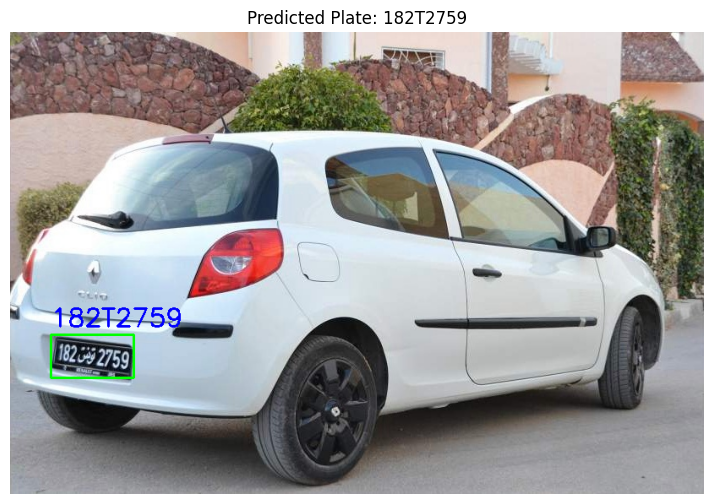

In [6]:
from google.colab import files
uploaded = files.upload()  # Pick an image from your device

img_path = list(uploaded.keys())[0]
print("✅ Uploaded image:", img_path)

import os
import cv2
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torch import nn

# === CONFIG ===
YOLO_MODEL_PATH = "plate_detector_v2/weights/best.pt"
CRNN_MODEL_PATH = "ocr_crnn_best.pth"
IMG_WIDTH, IMG_HEIGHT = 160, 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHARS = string.digits + string.ascii_uppercase + 'T'
CHAR_TO_IDX = {c: i+1 for i, c in enumerate(CHARS)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}

# === CRNN Model ===
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1)),
        )
        self.rnn = nn.LSTM(1024, 256, bidirectional=True, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, num_classes + 1)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.rnn(x)
        x = self.fc(x[:, :, :512])
        return x.permute(1, 0, 2)

# === Decoder ===
def decode_prediction(logits):
    pred = torch.argmax(logits, dim=2).permute(1, 0)
    results = []
    for seq in pred:
        prev = -1
        text = ""
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != 0:
                text += IDX_TO_CHAR.get(idx, "?")
            prev = idx
        results.append(text)
    return results
# Load models
yolo_model = YOLO(YOLO_MODEL_PATH)
crnn_model = CRNN(len(CHARS)).to(DEVICE)
crnn_model.load_state_dict(torch.load(CRNN_MODEL_PATH, map_location=DEVICE))
crnn_model.eval()

# Run YOLO on image
results = yolo_model(img_path)
boxes = results[0].boxes.xyxy.cpu().numpy()
img = cv2.imread(img_path)

if len(boxes) == 0:
    print("🚫 No license plate detected.")
else:
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        plate = img[y1:y2, x1:x2]

        # OCR Preprocessing
        gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_WIDTH, IMG_HEIGHT))
        norm = resized / 255.0
        input_tensor = torch.tensor(norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Predict
        with torch.no_grad():
            logits = crnn_model(input_tensor)
        decoded = decode_prediction(logits)[0]
        print("🔍 Predicted Plate:", decoded)

        # Annotate image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, decoded, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted Plate: {decoded}")
    plt.show()
